### Read libraries

In [1]:
import json
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from matplotlib import rc
%matplotlib inline
import numpy as np
import geojson
import jenkspy
import altair as alt
alt.renderers.enable('notebook')

import altair as alt
import altair_latimes as lat
alt.renderers.enable('notebook')
# alt.themes.register('latimes', lat.theme)
# alt.themes.enable('latimes')

pd.set_option('display.max_columns', None)

### Load full list of donations to county candidates since 2007

In [2]:
contributions = pd.read_csv('input/contributions.csv',low_memory=False, dtype={'contributor_zip_code': 'str', 'contributor_zip_code_ext': 'str'})

contributions.contributor_address_2 = contributions.contributor_address_2.fillna('')
contributions.occupation = contributions.occupation.fillna('')
contributions.employer = contributions.employer.fillna('')
contributions.description = contributions.description.fillna('')
contributions.contributor_first_name = contributions.contributor_first_name.fillna('')
contributions.contributor_zip_code_ext = contributions.contributor_zip_code_ext.fillna('')

### Clean up the table

In [3]:
#names
contributions['amount_rcvd'] = contributions['amount_rcvd'].astype(int)
contributions['monthyear'] = pd.to_datetime(contributions['date']).map(lambda dt: dt.replace(day=1))
contributions['type'] = contributions['type'].str.replace("Small Contributor Committee", "Small Donor Committee")
contributions['first_name'] = contributions['first_name'].str.upper()
contributions['last_name'] = contributions['last_name'].str.upper()
contributions['committee_name'] = contributions['committee_name'].str.upper()
contributions['candidate_name'] =  contributions["first_name"].str.title() + ' ' + contributions["last_name"].str.title()
contributions['candidate_name'] = contributions['candidate_name'].str.replace('Holly J. Mitchell', 'Holly Mitchell')
contributions['first_name'] = contributions['first_name'].str.replace('HOLLY J.', 'HOLLY')
contributions["nu_contributor_address"] = contributions["contributor_address"].str.split('#').str[0].str.split(', ').str[0].str.split('Ste').str[0].str.split('Suite').str[0].str.split(',').str[0]
contributions['full_address'] =  contributions["nu_contributor_address"] + ', ' + contributions["contributor_city"] + ', ' + contributions["contributor_state"] + ', ' + contributions["contributor_zip_code"].astype(str)
contributions['candidate_slug'] =  contributions["first_name"].str.lower() + '_' + contributions["last_name"].str.lower()
contributions['candidate_slug'] = contributions['candidate_slug'].str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('.', '').str.replace('\'', '')

#time
contributions['date'] = pd.to_datetime(contributions['date'])
contributions['year'], contributions['month'] = contributions['date'].dt.year, contributions['date'].dt.month
contributions['year'] = contributions['year'].astype(str)
contributions['month'] = contributions['month'].astype(str)
contributions['months'] = contributions['date'].dt.strftime('%m/%Y').astype(str)
contributions['week'] = contributions['date'].dt.week
contributions['week'] = contributions['week'].astype(str)

### Filter data for recent contributions and money in the District 2 race

In [4]:
recent_contributions = contributions[(contributions['date'] > '2018-06-30')]
second_district_candidates = (['Holly Mitchell','Herb Wesson','Jan Perry','Chan Jeong'])
districttwo = recent_contributions[recent_contributions['candidate_name'].isin(second_district_candidates)]

In [5]:
districttwo.candidate_name.value_counts()

Herb Wesson       976
Jan Perry         895
Holly Mitchell    775
Chan Jeong         82
Name: candidate_name, dtype: int64

### How much did the candidates raise from all locations? 

In [6]:
second_district_totals = districttwo.groupby(['candidate_name'])['amount_rcvd'].sum().reset_index().sort_values(by='candidate_name', ascending=False)

In [7]:
second_district_totals

candidate_name  amount_rcvd
3       Jan Perry       512760
2  Holly Mitchell       568966
1     Herb Wesson      1134738
0      Chan Jeong        46100

In [8]:
sum_all_donations = second_district_totals['amount_rcvd'].sum()

In [9]:
second_district_avg = districttwo.groupby(['candidate_name'])['amount_rcvd'].mean().reset_index().sort_values(by='candidate_name', ascending=False)

In [10]:
second_district_avg.round()

candidate_name  amount_rcvd
3       Jan Perry        573.0
2  Holly Mitchell        734.0
1     Herb Wesson       1163.0
0      Chan Jeong        562.0

In [11]:
districttwo.to_csv('output/district_two.csv')

### How many individual donations did each candidate receive? 

In [12]:
#Remap donation 'type' codes to be more descriptive
# abbr_indiv_types = {'C' : 'Committee', 'I' : 'Individual', 'O' : 'Other', 'S' : 'Small Committee'}
abbr_indiv_else = {'C' : 'Other', 'I' : 'Individual', 'O' : 'Other', 'S' : 'Other'}
districttwo = districttwo.replace({"type": abbr_indiv_else})

In [13]:
second_district_indiv = pd.pivot_table(districttwo, values='amount_rcvd', index=['candidate_name'], columns=['type'], aggfunc=[np.size], fill_value='0').reset_index()

second_district_indiv.reset_index()

index  candidate_name       size      
type                       Individual Other
0        0      Chan Jeong         64    18
1        1     Herb Wesson        630   346
2        2  Holly Mitchell        454   321
3        3       Jan Perry        796    99

### Which share of each candidates donations came from individuals?

In [14]:
indiv_share = pd.pivot_table(districttwo, values=["amount_rcvd"],
                       index=["candidate_name"], columns=["type"], 
                       aggfunc=len, margins=True, 
                       dropna=True, fill_value=0)
indiv_share_table = indiv_share.div(indiv_share.iloc[:,-1], axis=0).round(2)*100
indiv_share_table.reset_index()

candidate_name amount_rcvd             
type                  Individual Other    All
0         Chan Jeong        78.0  22.0  100.0
1        Herb Wesson        65.0  35.0  100.0
2     Holly Mitchell        59.0  41.0  100.0
3          Jan Perry        89.0  11.0  100.0
4                All        71.0  29.0  100.0

### Normalized bar chart for the share of individual donations

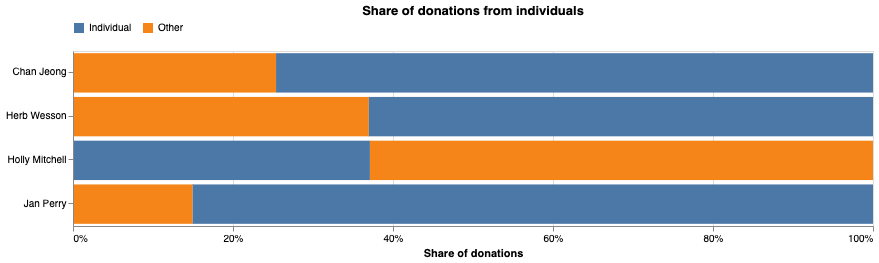

In [15]:
bars = alt.Chart(districttwo, title='Share of donations from individuals').mark_bar().encode(
    x=alt.X('sum(amount_rcvd)', stack="normalize", title="Share of donations",axis=alt.Axis(format='%', tickCount=6)),
    y=alt.Y('candidate_name', title=""),
    color=alt.Color('type',legend=alt.Legend(title="", orient='top')),
    order=alt.Order('sum(amount_rcvd)', sort='ascending')
)

(bars).properties(height=175, width=800)

## Where exactly is each donation? 

In [16]:
#after geocoder.ipynb runs, import raw table with lat/lon for each grouped address in 'contributions'

geocoded = pd.read_csv('/Users/mhustiles/Desktop/github/notebooks/campaign-finance/input/geocoded.csv')

In [17]:
geocoded.head(1)

id accuracy                                  formatted_address  \
0   0  ROOFTOP  1250 Long Beach Ave # 104, Los Angeles, CA 900...   

               google_place_id  \
0  ChIJ11zqyoLIwoARZ2-vjBhFJzg   

                                       input_string   latitude   longitude  \
0  1250 Long Beach Ave. 104, Los Angeles, CA, 90021  34.026282 -118.240472   

   number_of_results postcode  \
0                  1    90021   

                                            response status  \
0  {'results': [{'address_components': [{'long_na...     OK   

                              type  
0  establishment,point_of_interest

### How good was Google's geocoding API? 

In [18]:
geocoded.accuracy.value_counts()

ROOFTOP               44116
RANGE_INTERPOLATED     1131
APPROXIMATE             342
GEOMETRIC_CENTER        323
Name: accuracy, dtype: int64

In [19]:
geocoded_clean = geocoded[['accuracy', 'formatted_address', 'input_string', 'latitude', 'longitude']]

### Merge geocoded data onto our 2nd District contributions table

In [20]:
geocoded_join = districttwo.merge(geocoded_clean,left_on='full_address', right_on='input_string', how='left')

In [21]:
len(geocoded_join)

2728

In [22]:
geocoded_join.groupby(["accuracy"])["amount_rcvd"].size()

accuracy
APPROXIMATE             16
GEOMETRIC_CENTER        15
RANGE_INTERPOLATED      48
ROOFTOP               2649
Name: amount_rcvd, dtype: int64

In [23]:
(((geocoded_join.amount_rcvd.sum() - geocoded_join[geocoded_join.accuracy != "ROOFTOP"].amount_rcvd.sum()) / geocoded_join.amount_rcvd.sum())*100).round(2)

97.21

### Let's eliminate donations where Google could find the address. 

In [24]:
geocoded_join = geocoded_join[geocoded_join.accuracy == "ROOFTOP"]

In [25]:
len(geocoded_join)

2649

### Transform locations dataframe into Geo DataFrame (with appropriate coordinate system)

In [26]:
geocoded_join_gdf = gpd.GeoDataFrame(geocoded_join, geometry=gpd.points_from_xy(geocoded_join.longitude, geocoded_join.latitude))

In [27]:
geocoded_join_gdf.crs = {'init': "epsg:4326"}

In [28]:
geocoded_join_gdf.head()

last_name first_name committee_id              committee_name office_type  \
0    WESSON       HERB      1414475  WESSON FOR SUPERVISOR 2020         CSU   
1    WESSON       HERB      1414475  WESSON FOR SUPERVISOR 2020         CSU   
2    WESSON       HERB      1414475  WESSON FOR SUPERVISOR 2020         CSU   
3    WESSON       HERB      1414475  WESSON FOR SUPERVISOR 2020         CSU   
4    WESSON       HERB      1414475  WESSON FOR SUPERVISOR 2020         CSU   

  district_number schedule   type period_beg_date period_end_date  \
0             NaN        A  Other          1/1/18        12/31/18   
1             NaN        A  Other          1/1/18        12/31/18   
2             NaN        A  Other          1/1/18        12/31/18   
3             NaN        A  Other          1/1/18        12/31/18   
4             NaN        A  Other          1/1/18        12/31/18   

  election_date       date  amount_rcvd  amount_pd description  \
0           NaN 2018-12-11         1500        0.0               
1           NaN 2018-12-14         1500        0.0               
2           NaN 2018-12-18         1500        0.0               
3           NaN 2018-12-18         1500        0.0               
4           NaN 2018-12-18         1500        0.0               

  contributor_first_name                              contributor_last_name  \
0                                               UFCW Western States Council   
1                                                        UFCW Local 324 PAC   
2                         Angelenos for Safe Transportation PAC Sponsore...   
3                         United Food and Commercial Workers Internation...   
4                         United Food and Commercial Workers Union Local...   

  contributor_address contributor_address_2 contributor_city  \
0    8530 Stanton Ave                Ste 2A       Buena Park   
1    8530 Stanton Ave                             Buena Park   
2    249 E Ocean Blvd               Ste 685       Long Beach   
3        1775 K St NW                  Bsmt       Washington   
4       630 Shatto Pl                            Los Angeles   

  contributor_state contributor_zip_code contributor_zip_code_ext occupation  \
0                CA                90620                     3930              
1                CA                90620                     3930              
2                CA                90802                     8832              
3                DC                20006                     1521              
4                CA                90005                     1303              

  employer  rec_id      cycle  monthyear candidate_name  \
0             2546  2018-2019 2018-12-01    Herb Wesson   
1             2546  2018-2019 2018-12-01    Herb Wesson   
2             2546  2018-2019 2018-12-01    Herb Wesson   
3             2546  2018-2019 2018-12-01    Herb Wesson   
4             2546  2018-2019 2018-12-01    Herb Wesson   

  nu_contributor_address                             full_address  \
0       8530 Stanton Ave  8530 Stanton Ave, Buena Park, CA, 90620   
1       8530 Stanton Ave  8530 Stanton Ave, Buena Park, CA, 90620   
2       249 E Ocean Blvd  249 E Ocean Blvd, Long Beach, CA, 90802   
3           1775 K St NW      1775 K St NW, Washington, DC, 20006   
4          630 Shatto Pl    630 Shatto Pl, Los Angeles, CA, 90005   

  candidate_slug  year month   months week accuracy  \
0    herb_wesson  2018    12  12/2018   50  ROOFTOP   
1    herb_wesson  2018    12  12/2018   50  ROOFTOP   
2    herb_wesson  2018    12  12/2018   51  ROOFTOP   
3    herb_wesson  2018    12  12/2018   51  ROOFTOP   
4    herb_wesson  2018    12  12/2018   51  ROOFTOP   

                             formatted_address  \
0  8530 Stanton Ave, Buena Park, CA 90620, USA   
1  8530 Stanton Ave, Buena Park, CA 90620, USA   
2  249 E Ocean Blvd, Long Beach, CA 90802, USA   
3      1775 K St NW, Washington, DC 20006, USA   
4    630 Shatto Pl, Los

## Import and use LA County geography

### Read the Census blocks, with population/household figures added by county officials

In [29]:
#http://public.gis.lacounty.gov/public/rest/services/LACounty_Dynamic/Demographics/MapServer/3
blocks = gpd.read_file('/Users/mhustiles/Desktop/data/GIS/LA/LA_county_census_blocks_2010/la_county_blocks_2010_data.geojson')

In [30]:
blocks.columns = blocks.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [31]:
blocks = blocks.to_crs({'init': "epsg:4326"})

In [32]:
len(blocks)

109279

In [33]:
blocks.columns

Index(['objectid', 'ct10', 'bg10', 'cb10', 'ctcb10', 'bg10fip10', 'cen_fip13',
       'la_fip10', 'city', 'comm', 'citycom', 'zcta10', 'puma10', 'hd_2012',
       'hd_name', 'spa_2012', 'spa_name', 'sup_dist', 'sup_label', 'housing10',
       'pop_2010', 'shape.starea', 'shape.stlength', 'ct12', 'bg12',
       'geometry'],
      dtype='object')

In [34]:
blocks['geoid10'] = blocks['ctcb10']

### Merge our contributions/locations data to Census blocks

In [35]:
dist_two_blocks = gpd.sjoin(geocoded_join_gdf, blocks, op='within', how="inner")

In [36]:
dist_two_blocks.columns = dist_two_blocks.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [37]:
second_district_blocks = dist_two_blocks[(dist_two_blocks['last_name'] == 'WESSON') | (dist_two_blocks['last_name'] == 'PERRY') | (dist_two_blocks['last_name'] == 'PERRY') | (dist_two_blocks['last_name'] == 'JEONG') | (dist_two_blocks['last_name'] == 'MITCHELL')]

In [38]:
second_district_blocks.first_name.value_counts()

JAN      780
HERB     756
HOLLY    398
CHAN      72
Name: first_name, dtype: int64

In [39]:
second_district_blocks.to_file("/Users/mhustiles/Desktop/github/notebooks/campaign-finance/output/second_district_blocks.geojson", driver="GeoJSON")

In [40]:
second_district_blocks.head(2)

last_name first_name committee_id              committee_name office_type  \
2    WESSON       HERB      1414475  WESSON FOR SUPERVISOR 2020         CSU   
7    WESSON       HERB      1414475  WESSON FOR SUPERVISOR 2020         CSU   

  district_number schedule   type period_beg_date period_end_date  \
2             NaN        A  Other          1/1/18        12/31/18   
7             NaN        A  Other          1/1/18        12/31/18   

  election_date       date  amount_rcvd  amount_pd description  \
2           NaN 2018-12-18         1500        0.0               
7           NaN 2018-12-21         1500        0.0               

  contributor_first_name                              contributor_last_name  \
2                         Angelenos for Safe Transportation PAC Sponsore...   
7                                        Janna Zurita for City Council 2019   

  contributor_address contributor_address_2 contributor_city  \
2    249 E Ocean Blvd               Ste 685       Long Beach   
7    249 E Ocean Blvd               Ste 685       Long Beach   

  contributor_state contributor_zip_code contributor_zip_code_ext occupation  \
2                CA                90802                     8832              
7                CA                90802                     8832              

  employer  rec_id      cycle  monthyear candidate_name  \
2             2546  2018-2019 2018-12-01    Herb Wesson   
7             2546  2018-2019 2018-12-01    Herb Wesson   

  nu_contributor_address                             full_address  \
2       249 E Ocean Blvd  249 E Ocean Blvd, Long Beach, CA, 90802   
7       249 E Ocean Blvd  249 E Ocean Blvd, Long Beach, CA, 90802   

  candidate_slug  year month   months week accuracy  \
2    herb_wesson  2018    12  12/2018   51  ROOFTOP   
7    herb_wesson  2018    12  12/2018   51  ROOFTOP   

                             formatted_address  \
2  249 E Ocean Blvd, Long Beach, CA 90802, USA   
7  249 E Ocean Blvd, Long Beach, CA 90802, USA   

                              input_string   latitude   longitude  \
2  249 E Ocean Blvd, Long Beach, CA, 90802  33.767313 -118.190096   
7  249 E Ocean Blvd, Long Beach, CA, 90802  33.767313 -118.190096   

                                 geometry  index_right  objectid    ct10  \
2  POINT (-118.1900963 33.76731270000001)        81712     69170  576001   
7  POINT (-118.1900963 33.76731270000001)        81712     69170  576001   

      bg10  cb10      ctcb10     bg10fip10 cen_fip13 la_fip10        city  \
2  5760012  2053  5760012053  576001243000     43000    43000  Long Beach   
7  5760012  2053  5760012053  576001243000     43000    43000  Long Beach   

         comm             citycom zcta10 puma10  hd_2012     hd_name  \
2  Long Beach  City of Long Beach  90802  03766       40  Long Beach   
7  Long Beach  City of Long Beach  90802  03766       40  Long Beach   

   spa_2012   spa_name sup_dist   sup_label  housing10  pop_2010  \
2         8  South Bay        4  District 4          0         0   
7         8  South Bay        4  District 4          0         0   

   shape.starea  shape.stlength    ct12     bg12     geoid10  
2  68632.442383     1069.300144  576001  5760012  5760012053  
7  68632.442383     1069.300144  576001  5760012  5760012053

## Donations by block

### How much did candidates raise by block?

In [41]:
sum_by_block = pd.pivot_table(second_district_blocks, values='amount_rcvd', index=['geoid10'], columns=['candidate_slug'], aggfunc=np.sum, fill_value=0).reset_index()
sum_by_block.columns = sum_by_block.columns.to_series().str.join('')

In [42]:
sum_by_block["total"] = sum_by_block.sum(axis=1)

### How much did all candidates raise in each block? 

In [43]:
sum_by_block = sum_by_block.sort_values("total", ascending=False)

In [44]:
sum_by_block.head(2)

candidate_slug     geoid10  chan_jeong  herb_wesson  holly_mitchell  \
1051            5760012053           0         8648            1000   
291             2077101011           0         3000            6615   

candidate_slug  jan_perry  total  
1051                    0   9648  
291                     0   9615

### How much was donated to all candidates from L.A. County blocks? 

In [45]:
sum_by_block.total.sum()

1578057

### How many blocks in LA County donated? 

In [46]:
sum_by_block.total.count()

1392

### Which 2nd District candidate received the most on each block? 

In [47]:
#create a dummy field because i'm bad at idxmax
sum_by_block['tie'] = '0'

In [48]:
#reshape dataframe
sum_by_block_slim = sum_by_block[['geoid10', 'tie','chan_jeong','herb_wesson','jan_perry','holly_mitchell','total']]

In [49]:
sum_by_block_slim['tie'] = sum_by_block_slim['tie'].astype(int)
sum_by_block_slim['geoid10'] = sum_by_block_slim['geoid10'].astype(str)

In [50]:
#who won each block?
sum_by_block_slim['winner_dist_two'] = sum_by_block_slim[['tie','chan_jeong','herb_wesson','jan_perry','holly_mitchell']].idxmax(axis=1)

In [51]:
#how much did each block winner raise from there? 
sum_by_block_slim['winner_total'] = sum_by_block_slim[['tie','chan_jeong','herb_wesson','jan_perry','holly_mitchell']].max(axis=1)

In [52]:
sum_by_block_slim['winner_dist_two'] = sum_by_block_slim['winner_dist_two'].str.title().str.replace('_',' ')

In [53]:
sum_by_block_slim.head()

candidate_slug     geoid10  tie  chan_jeong  herb_wesson  jan_perry  \
1051            5760012053    0           0         8648          0   
291             2077101011    0           0         3000          0   
391             2121021001    0         300         9300          0   
689             2677002027    0           0            0          0   
1362            8004061003    0           0         7500          0   

candidate_slug  holly_mitchell  total winner_dist_two  winner_total  
1051                      1000   9648     Herb Wesson          8648  
291                       6615   9615  Holly Mitchell          6615  
391                          0   9600     Herb Wesson          9300  
689                       7500   7500  Holly Mitchell          7500  
1362                         0   7500     Herb Wesson          7500

### Remove 2nd District rows with no contributions

In [54]:
sum_by_block_slim = sum_by_block_slim[(sum_by_block_slim['winner_total'] != 0)]

### How many blocks did each 2nd District candidate win?

In [55]:
sum_by_block_slim.winner_dist_two.value_counts()

Herb Wesson       578
Jan Perry         510
Holly Mitchell    244
Chan Jeong         56
Name: winner_dist_two, dtype: int64

### How much did each 2nd District candidate raise from just LA blocks?

In [56]:
sum_by_block_slim[['chan_jeong','herb_wesson','jan_perry','holly_mitchell']].agg('sum')

candidate_slug
chan_jeong         38100
herb_wesson       865551
jan_perry         455135
holly_mitchell    219271
dtype: int64

In [57]:
len(sum_by_block_slim)

1388

In [58]:
len(blocks)

109279

### Merge the blocks geography back onto our 2nd District winners table

In [59]:
second_district_blocks_geo = blocks.merge(sum_by_block_slim, on='geoid10')

In [60]:
second_district_blocks_geo.to_file('output/second_district_blocks_geo.geojson', driver="GeoJSON")

In [61]:
second_district_blocks_geo.head(2)

objectid    ct10     bg10  cb10      ctcb10     bg10fip10 cen_fip13  \
0    100013  701201  7012013  3004  7012013004  701201370000     70000   
1    100018  226002  2260021  1002  2260021002  226002144000     44000   

  la_fip10          city                comm  \
0    70000  Santa Monica        Santa Monica   
1    44000   Los Angeles  Wholesale District   

                            citycom zcta10 puma10  hd_2012  hd_name  spa_2012  \
0              City of Santa Monica  90402  03728       84     West         5   
1  Los Angeles - Wholesale District  90014  03744        9  Central         4   

  spa_name sup_dist   sup_label  housing10  pop_2010   shape.starea  \
0     West        3  District 3         24        53  277860.669922   
1    Metro        2  District 2          0         4  336977.663086   

   shape.stlength    ct12     bg12  \
0     2269.243366  701201  7012013   
1     2554.521020  226002  2260021   

                                            geometry     geoid10  tie  \
0  POLYGON ((-118.4938122283859 34.03863684039477...  7012013004    0   
1  POLYGON ((-118.2485401870849 34.04194385415874...  2260021002    0   

   chan_jeong  herb_wesson  jan_perry  holly_mitchell  total winner_dist_two  \
0           0         1500          0               0   1500     Herb Wesson   
1           0            0       1500               0   1500       Jan Perry   

   winner_total  
0          1500  
1          1500

### 2nd District winners table to MBTiles

In [62]:
!tippecanoe -z15 -f -o output/second_district_blocks_geo.mbtiles output/second_district_blocks_geo.geojson

For layer 0, using name "second_district_blocks_geo"
1388 features, 397385 bytes of geometry, 3555 bytes of separate metadata, 121379 bytes of string pool
  99.9%  15/5585/13072  


## Donations by *Los Angeles Times* neighborhoods

In [63]:
neighborhoods = gpd.read_file('/Users/mhustiles/Desktop/data/GIS/LA/la-county-city-neighborhoods.geojson')
neighborhoods.columns = neighborhoods.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

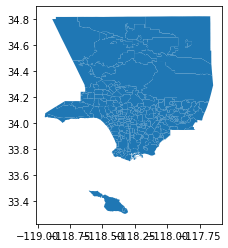

In [64]:
neighborhoods.plot()

In [65]:
second_district_hoods = gpd.sjoin(geocoded_join_gdf, neighborhoods, op='within', how="inner")

In [66]:
second_district_hoods.head(2)

last_name first_name committee_id              committee_name office_type  \
2    WESSON       HERB      1414475  WESSON FOR SUPERVISOR 2020         CSU   
7    WESSON       HERB      1414475  WESSON FOR SUPERVISOR 2020         CSU   

  district_number schedule type_left period_beg_date period_end_date  \
2             NaN        A     Other          1/1/18        12/31/18   
7             NaN        A     Other          1/1/18        12/31/18   

  election_date       date  amount_rcvd  amount_pd description  \
2           NaN 2018-12-18         1500        0.0               
7           NaN 2018-12-21         1500        0.0               

  contributor_first_name                              contributor_last_name  \
2                         Angelenos for Safe Transportation PAC Sponsore...   
7                                        Janna Zurita for City Council 2019   

  contributor_address contributor_address_2 contributor_city  \
2    249 E Ocean Blvd               Ste 685       Long Beach   
7    249 E Ocean Blvd               Ste 685       Long Beach   

  contributor_state contributor_zip_code contributor_zip_code_ext occupation  \
2                CA                90802                     8832              
7                CA                90802                     8832              

  employer  rec_id      cycle  monthyear candidate_name  \
2             2546  2018-2019 2018-12-01    Herb Wesson   
7             2546  2018-2019 2018-12-01    Herb Wesson   

  nu_contributor_address                             full_address  \
2       249 E Ocean Blvd  249 E Ocean Blvd, Long Beach, CA, 90802   
7       249 E Ocean Blvd  249 E Ocean Blvd, Long Beach, CA, 90802   

  candidate_slug  year month   months week accuracy  \
2    herb_wesson  2018    12  12/2018   51  ROOFTOP   
7    herb_wesson  2018    12  12/2018   51  ROOFTOP   

                             formatted_address  \
2  249 E Ocean Blvd, Long Beach, CA 90802, USA   
7  249 E Ocean Blvd, Long Beach, CA 90802, USA   

                              input_string   latitude   longitude  \
2  249 E Ocean Blvd, Long Beach, CA, 90802  33.767313 -118.190096   
7  249 E Ocean Blvd, Long Beach, CA, 90802  33.767313 -118.190096   

                                 geometry  index_right        slug  \
2  POINT (-118.1900963 33.76731270000001)          135  long-beach   
7  POINT (-118.1900963 33.76731270000001)          135  long-beach   

                                   set                                kind  \
2  L.A. County Neighborhoods (Current)  L.A. County Neighborhood (Current)   
7  L.A. County Neighborhoods (Current)  L.A. County Neighborhood (Current)   

   external_i        name                                     display_na  \
2  long-beach  Long Beach  Long Beach L.A. County Neighborhood (Current)   
7  long-beach  Long Beach  Long Beach L.A. County Neighborhood (Current)   

            sqmi       type_right name_1 slug_1  
2  52.1003673205  standalone-city   None   None  
7  52.1003673205  standalone-city   None   None

In [67]:
second_district_hoods.columns = second_district_hoods.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

### How much did each of the candidates raise by neighborhood?

In [68]:
sum_by_hood = pd.pivot_table(second_district_hoods, values='amount_rcvd', index=['name'], columns=['candidate_slug'], aggfunc=np.sum, fill_value=0).reset_index()

In [69]:
sum_by_hood["total"] = sum_by_hood.sum(axis=1)

In [70]:
sum_by_hood.columns = sum_by_hood.columns.to_series().str.join('')

### How much did all of the candidates raise by neighborhood?

In [71]:
sum_by_hood = sum_by_hood.sort_values("total", ascending=False)

In [72]:
sum_by_hood.head()

candidate_slug           name  chan_jeong  herb_wesson  holly_mitchell  \
45                   Downtown        2750        63788           13965   
85                  Koreatown        7900        82850            8000   
16              Beverly Hills           0        46150            4100   
20                  Brentwood           0        15949            7000   
96                 Long Beach         500        30248            3750   

candidate_slug  jan_perry   total  
45                  68300  148803  
85                   4350  103100  
16                  26080   76330  
20                  28350   51299  
96                   5250   39748

In [73]:
sum_by_hood[['name', 'total']].sort_values(by='total', ascending=False)

candidate_slug                     name   total
45                             Downtown  148803
85                            Koreatown  103100
16                        Beverly Hills   76330
20                            Brentwood   51299
96                           Long Beach   39748
140                        Santa Monica   38150
179                            Westwood   36000
54                               Encino   33800
120                            Pasadena   31055
141                            Sawtelle   27710
28                         Century City   26775
103                        Mid-Wilshire   26185
90                       Ladera Heights   25275
175                         Westchester   24300
99                      Manhattan Beach   23800
176                            Westlake   22450
166             View Park-Windsor Hills   22306
97                            Los Feliz   21650
40                          Culver City   20200
68                         Hancock Park   19750
80                 Hollywood Hills West   19000
163                              Venice   18300
78                            Hollywood   18000
184                      Woodland Hills   17975
144                        Sherman Oaks   16900
113                   Pacific Palisades   16800
21                              Burbank   15750
183                      Windsor Square   15550
15                        Beverly Grove   14750
61                             Glendale   13600
..                                  ...     ...
133                     Rowland Heights    1100
26                      Castaic Canyons    1000
58                   Florence-Firestone    1000
151                          Sun Valley    1000
121                         Pico Rivera    1000
94                             Lawndale    1000
7                                Athens     900
49                            Echo Park     850
134                           San Dimas     800
164                      Vermont Square     800
160                         Valley Glen     800
48                     East Los Angeles     750
169                          West Adams     600
114                             Pacoima     600
142                     Sepulveda Basin     500
118                       Panorama City     500
115                            Palmdale     300
52                            El Sereno     250
60                        Glassell Park     250
34                            Chinatown     250
145                        Sierra Madre     225
55                      Exposition Park     200
170                         West Carson     200
156                             Tujunga     200
0                       Adams-Normandie     200
30                          Charter Oak     125
112                             Norwalk     125
13                           Bellflower     100
168                               Watts     100
39                               Covina     100

[185 rows x 2 columns]

### How much was donated to all candidates from L.A. County neighborhoods? 

In [74]:
sum_by_hood.total.sum()

1577557

### How many neighborhoods in LA County donated? 

In [75]:
sum_by_hood.total.count()

185

### Which 2nd District candidate received the most on each block? 

In [76]:
#create a dummy field because i'm bad at idxmax
sum_by_hood['tie'] = '0'

In [77]:
#reshape dataframe
sum_by_hood_winner = sum_by_hood[['name', 'tie','chan_jeong','herb_wesson','jan_perry','holly_mitchell','total']]

In [78]:
sum_by_hood_winner['tie'] = sum_by_hood_winner['tie'].astype(int)
sum_by_hood_winner['name'] = sum_by_hood_winner['name'].astype(str)

In [79]:
#who won each block?
sum_by_hood_winner['winner_dist_two'] = sum_by_hood_winner[['tie','chan_jeong','herb_wesson','jan_perry','holly_mitchell']].idxmax(axis=1)

In [80]:
#how much did each block winner raise from there? 
sum_by_hood_winner['winner_total'] = sum_by_hood_winner[['tie','chan_jeong','herb_wesson','jan_perry','holly_mitchell']].max(axis=1)

In [81]:
sum_by_hood_winner['winner_dist_two']= sum_by_hood_winner['winner_dist_two'].str.title().str.replace('_',' ')

### Which were the top neighborhoods for each candidate? 

In [82]:
sum_by_hood_winner

candidate_slug                     name  tie  chan_jeong  herb_wesson  \
45                             Downtown    0        2750        63788   
85                            Koreatown    0        7900        82850   
16                        Beverly Hills    0           0        46150   
20                            Brentwood    0           0        15949   
96                           Long Beach    0         500        30248   
140                        Santa Monica    0           0        18750   
179                            Westwood    0           0        18500   
54                               Encino    0           0        24100   
120                            Pasadena    0           0        12950   
141                            Sawtelle    0           0         6125   
28                         Century City    0        1500        14000   
103                        Mid-Wilshire    0        2950         9500   
90                       Ladera Heights    0           0         6800   
175                         Westchester    0           0        15900   
99                      Manhattan Beach    0           0        23300   
176                            Westlake    0        5600        10750   
166             View Park-Windsor Hills    0           0         7800   
97                            Los Feliz    0           0        14750   
40                          Culver City    0           0         8600   
68                         Hancock Park    0         600         7800   
80                 Hollywood Hills West    0           0         9350   
163                              Venice    0           0        11100   
78                            Hollywood    0         250         9750   
184                      Woodland Hills    0           0        11200   
144                        Sherman Oaks    0           0         9600   
113                   Pacific Palisades    0           0        10500   
21                              Burbank    0           0         7000   
183                      Windsor Square    0        2000         5000   
15                        Beverly Grove    0           0        11250   
61                             Glendale    0        1500         5500   
..                                  ...  ...         ...          ...   
131                       Rolling Hills    0           0            0   
26                      Castaic Canyons    0           0         1000   
58                   Florence-Firestone    0           0         1000   
151                          Sun Valley    0           0         1000   
121                         Pico Rivera    0           0            0   
94                             Lawndale    0           0            0   
7                                Athens    0           0          800   
49                            Echo Park    0         500            0   
160                         Valley Glen    0         700            0   
164                      Vermont Square    0           0          500   
134                           San Dimas    0           0          800   
48                     East Los Angeles    0           0          500   
169                          West Adams    0           0          250   
114                             Pacoima    0         100          500   
142                     Sepulveda Basin    0           0          500   
118                       Panorama City    0           0            0   
115                            Palmdale    0           0            0   
52                            El Sereno    0           0            0   
60                        Glassell Park    0         250            0   
34                            Chinatown    0           0            0   
145                        Sierra Madre    0           0            0   
55                      Exposition Park    0         200            0   
170                         West Carson    0         200  

In [83]:
sum_by_hood_winner.to_csv('output/sum_by_hood_winner.csv')

### Remove 2nd District rows with no contributions

In [84]:
sum_by_hood_winner = sum_by_hood_winner[(sum_by_hood_winner['winner_total'] != 0)]

In [85]:
len(sum_by_hood_winner)

185

### How many neighborhoods did each 2nd District candidate win?

In [86]:
sum_by_hood_winner.winner_dist_two.value_counts()

Herb Wesson       120
Jan Perry          43
Holly Mitchell     16
Chan Jeong          6
Name: winner_dist_two, dtype: int64

### How much did each 2nd District candidate raise from just LA neighborhoods?

In [87]:
sum_by_hood_winner[['chan_jeong','herb_wesson','jan_perry','holly_mitchell']].agg('sum')

candidate_slug
chan_jeong         38100
herb_wesson       865051
jan_perry         455135
holly_mitchell    219271
dtype: int64

### Merge the neighborhoods/winner geography back onto our 2nd District winners table

In [88]:
second_district_hoods = neighborhoods.merge(sum_by_hood_winner, on='name')

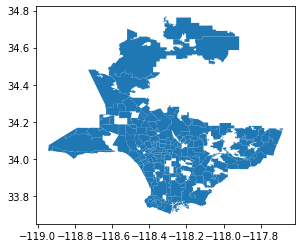

In [89]:
second_district_hoods.plot()

### Export spatial file with winners, totals by neighborhood

In [90]:
second_district_hoods.to_file('output/second_district_hoods_sum.geojson', driver="GeoJSON")

### Generic neighborhoods to MBTiles

In [91]:
!tippecanoe -z15 -f -o output/la-county-city-neighborhoods.mbtiles /Users/mhustiles/Desktop/data/GIS/LA/la-county-city-neighborhoods.geojson

For layer 0, using name "lacountycityneighborhoods"
272 features, 122892 bytes of geometry, 10151 bytes of separate metadata, 25186 bytes of string pool
  99.9%  15/5597/13039  


## Plot the donations

### Choropleth map with neighborhood totals

In [92]:
breaks = jenkspy.jenks_breaks(second_district_hoods.winner_total, nb_class=7)

In [93]:
def get_group(value):
    for i, b in enumerate(breaks):
        if value <= breaks[i+1]:
            return i

In [94]:
second_district_hoods['winner_group'] = second_district_hoods.winner_total.apply(get_group)

In [95]:
second_district_hoods['id'] = second_district_hoods.index + 1
second_district_hoods['id'] = second_district_hoods['id'].astype(str)

### Winner group data to file

In [96]:
second_district_hoods.to_file("output/second_district_hoods_winner_groups.geojson", driver="GeoJSON")

In [97]:
!tippecanoe -zg -f -o output/second_district_hoods_winner_groups.mbtiles --generate-ids output/second_district_hoods_winner_groups.geojson

For layer 0, using name "second_district_hoods_winner_groups"
185 features, 103603 bytes of geometry, 15257 bytes of separate metadata, 19216 bytes of string pool
Choosing a maxzoom of -z5 for features about 15861 feet (4835 meters) apart
Choosing a maxzoom of -z8 for resolution of about 1022 feet (311 meters) within features
  99.9%  8/43/102  


In [98]:
second_district_hoods.loc[[0]]

slug                                  set  \
0  adams-normandie  L.A. County Neighborhoods (Current)   

                                 kind       external_i             name  \
0  L.A. County Neighborhood (Current)  adams-normandie  Adams-Normandie   

                                          display_na            sqmi  \
0  Adams-Normandie L.A. County Neighborhood (Curr...  0.805350187789   

                type name_1 slug_1  \
0  segment-of-a-city   None   None   

                                            geometry  tie  chan_jeong  \
0  (POLYGON ((-118.3090080000001 34.0374109991240...    0           0   

   herb_wesson  jan_perry  holly_mitchell  total winner_dist_two  \
0            0        200               0    200       Jan Perry   

   winner_total  winner_group id  
0           200             0  1

### Export to MBTiles

In [99]:
# !tippecanoe -z16 -f -o output/second_district_hoods_winner_groups.mbtiles output/second_district_hoods_winner_groups.geojson

### Feed GeoJSON to Altair

In [100]:
geojson = json.loads(second_district_hoods.to_json())

In [101]:
features = alt.Data(values=geojson['features'])

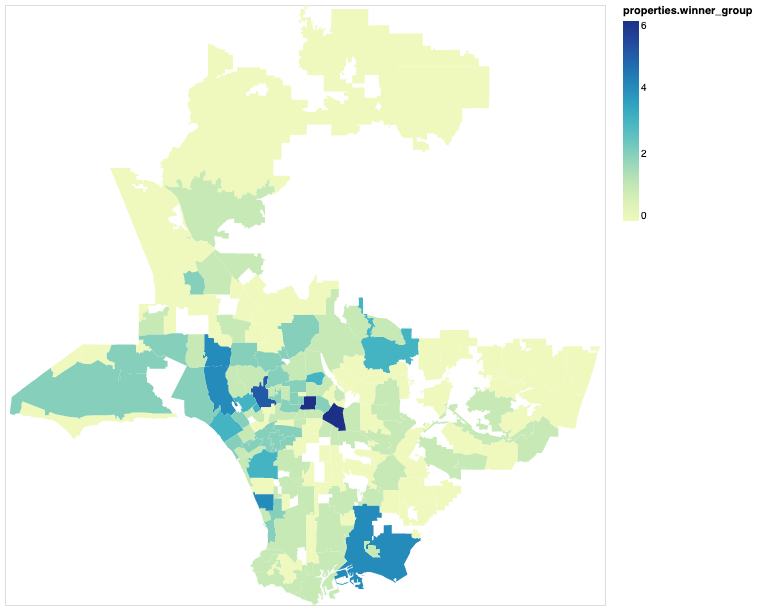

In [102]:
alt.Chart(features).mark_geoshape().encode(
    color='properties.winner_group:Q'
).properties(
    width=600,
    height=600
)

### Categorical map with winners

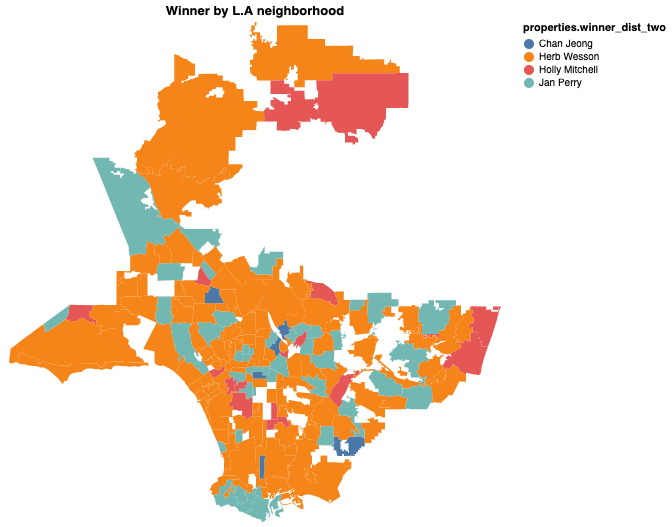

In [103]:
alt.Chart(features).mark_geoshape().encode(
    color='properties.winner_dist_two:N',
).properties(
    width=500,
    height=500, title='Winner by L.A neighborhood'
).configure_view(
    strokeWidth=0
)

### How much did each candidate raise — by month — in 2019? 

In [104]:
districttwo_time = districttwo.groupby(['monthyear','year','month', 'candidate_name'], as_index=False).agg({'amount_rcvd': ['size', 'mean', 'sum']}, as_index=False)

flat_columns = [''.join(t) for t in districttwo_time.columns]
districttwo_time.columns = flat_columns
districttwo_time['amount_rcvdmean'] = districttwo_time['amount_rcvdmean'].astype(int)
districttwo_time['amount_rcvdmean'] = districttwo_time['amount_rcvdmean'].round()
districttwo_time.head(10)
districttwo_time['months'] = districttwo_time['monthyear'].dt.strftime('%b').astype(str)
districttwo_time['week'] = districttwo_time['monthyear'].dt.week

districttwo_time

monthyear  year month  candidate_name  amount_rcvdsize  amount_rcvdmean  \
0  2018-12-01  2018    12     Herb Wesson              357             1275   
1  2019-01-01  2019     1     Herb Wesson               78             1048   
2  2019-01-01  2019     1       Jan Perry               59              642   
3  2019-02-01  2019     2     Herb Wesson               38             1056   
4  2019-02-01  2019     2  Holly Mitchell              477              837   
5  2019-02-01  2019     2       Jan Perry               95              846   
6  2019-03-01  2019     3     Herb Wesson              144             1191   
7  2019-03-01  2019     3  Holly Mitchell               20              574   
8  2019-03-01  2019     3       Jan Perry              112              670   
9  2019-04-01  2019     4     Herb Wesson              102             1086   
10 2019-04-01  2019     4  Holly Mitchell               83              527   
11 2019-04-01  2019     4       Jan Perry              126              534   
12 2019-05-01  2019     5      Chan Jeong               77              585   
13 2019-05-01  2019     5     Herb Wesson               99             1062   
14 2019-05-01  2019     5  Holly Mitchell               47              568   
15 2019-05-01  2019     5       Jan Perry               93              556   
16 2019-06-01  2019     6      Chan Jeong                5              200   
17 2019-06-01  2019     6     Herb Wesson              158             1075   
18 2019-06-01  2019     6  Holly Mitchell              148              589   
19 2019-06-01  2019     6       Jan Perry              410              488   

    amount_rcvdsum months  week  
0           455299    Dec    48  
1            81800    Jan     1  
2            37930    Jan     1  
3            40150    Feb     5  
4           399665    Feb     5  
5            80375    Feb     5  
6           171516    Mar     9  
7            11490    Mar     9  
8            75150    Mar     9  
9           110837    Apr    14  
10           43800    Apr    14  
11           67325    Apr    14  
12           45100    May    18  
13          105223    May    18  
14           26702    May    18  
15           51725    May    18  
16            1000    Jun    22  
17          169913    Jun    22  
18           87309    Jun    22  
19          200255    Jun    22

In [105]:
districttwo_time[(districttwo_time.candidate_name == 'Holly Mitchell')][['candidate_name', 'months', 'amount_rcvdsum']]

candidate_name months  amount_rcvdsum
4   Holly Mitchell    Feb          399665
7   Holly Mitchell    Mar           11490
10  Holly Mitchell    Apr           43800
14  Holly Mitchell    May           26702
18  Holly Mitchell    Jun           87309

In [106]:
second_district_totals

candidate_name  amount_rcvd
3       Jan Perry       512760
2  Holly Mitchell       568966
1     Herb Wesson      1134738
0      Chan Jeong        46100

In [107]:
base = alt.Chart(districttwo_time, title='').mark_bar().encode(
    x=alt.X("months:O", 
            timeUnit="yearmonth",
            title=" ",
            axis=alt.Axis(format="%b")
           ),
    y=alt.Y(
        'amount_rcvdsum:Q',
        title="",
        axis=alt.Axis(format="$1s", tickCount=5)
        )
    ).properties(height=225, width=225).facet(column = alt.Column('candidate_name:N', title=None), 
)
(base).configure_axisY(labelFontSize=15).configure_axisX(labelFontSize=15).configure_header(
    labelColor='black',
    labelFont='Benton Gothic',
    labelFontSize=15
)

### Load 2nd District boundary data

In [108]:
#http://public.gis.lacounty.gov/public/rest/services/LACounty_Dynamic/Demographics/MapServer/3
district = gpd.read_file('/Users/mhustiles/Desktop/data/GIS/LA/second-district.geojson')

### Export 2nd District boundary data to MBTiles

In [109]:
!tippecanoe -z15 -f -o output/second-district-boundary.mbtiles /Users/mhustiles/Desktop/data/GIS/LA/second-district.geojson

For layer 0, using name "seconddistrict"
1 features, 34253 bytes of geometry, 21 bytes of separate metadata, 119 bytes of string pool
  99.9%  15/5626/13101  


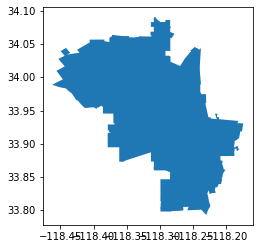

In [110]:
district.plot()

### Which share of each candidate's donations came from outside the district? 

In [111]:
district_donations = gpd.sjoin(geocoded_join_gdf, district, op='within', how="inner")

In [112]:
district_donations.head(1)

last_name first_name committee_id              committee_name office_type  \
4    WESSON       HERB      1414475  WESSON FOR SUPERVISOR 2020         CSU   

  district_number schedule   type period_beg_date period_end_date  \
4             NaN        A  Other          1/1/18        12/31/18   

  election_date       date  amount_rcvd  amount_pd description  \
4           NaN 2018-12-18         1500        0.0               

  contributor_first_name                              contributor_last_name  \
4                         United Food and Commercial Workers Union Local...   

  contributor_address contributor_address_2 contributor_city  \
4       630 Shatto Pl                            Los Angeles   

  contributor_state contributor_zip_code contributor_zip_code_ext occupation  \
4                CA                90005                     1303              

  employer  rec_id      cycle  monthyear candidate_name  \
4             2546  2018-2019 2018-12-01    Herb Wesson   

  nu_contributor_address                           full_address  \
4          630 Shatto Pl  630 Shatto Pl, Los Angeles, CA, 90005   

  candidate_slug  year month   months week accuracy  \
4    herb_wesson  2018    12  12/2018   51  ROOFTOP   

                           formatted_address  \
4  630 Shatto Pl, Los Angeles, CA 90005, USA   

                            input_string   latitude   longitude  \
4  630 Shatto Pl, Los Angeles, CA, 90005  34.062793 -118.289524   

                         geometry  index_right  OBJECTID DISTRICT       LABEL  \
4  POINT (-118.2895243 34.062793)            0       816        2  District 2   

   Shape.STArea()  Shape.STLength()  
4    4.511283e+09     477421.592662

In [113]:
district_totals = district_donations.groupby(['candidate_slug']).agg({'amount_rcvd':np.sum}).reset_index().sort_values(by='candidate_slug', ascending=False)

In [114]:
district_totals['outside'] = (second_district_totals.amount_rcvd - district_totals.amount_rcvd).round(2)
district_totals['share_district'] = (district_totals.amount_rcvd / second_district_totals.amount_rcvd * 100).round(2)
district_totals['share_outside'] = (100 - district_totals.share_district)
district_totals_clean = district_totals.rename(columns={"amount_rcvd": "inside", 'candidate_slug': 'candidate'})

In [115]:
district_totals_clean

candidate  inside  outside  share_district  share_outside
3       jan_perry   97380   415380           18.99          81.01
2  holly_mitchell   78981   489985           13.88          86.12
1     herb_wesson  227105   907633           20.01          79.99
0      chan_jeong   14450    31650           31.34          68.66

In [116]:
sum_outside_donations = district_totals['outside'].sum()
sum_outside_donations
sum_all_donations

2262564

### What share of the donations came outside the distrct?

In [117]:
((sum_outside_donations / sum_all_donations)*100).round()

82.0

In [118]:
district_totals_melt = pd.melt(district_totals_clean, col_level=0, id_vars=['candidate'], value_vars=['inside', 'outside'])

In [119]:
district_totals_melt['candidate'] = district_totals_melt['candidate'].str.replace('_',' ').str.title()
district_totals_melt

candidate variable   value
0       Jan Perry   inside   97380
1  Holly Mitchell   inside   78981
2     Herb Wesson   inside  227105
3      Chan Jeong   inside   14450
4       Jan Perry  outside  415380
5  Holly Mitchell  outside  489985
6     Herb Wesson  outside  907633
7      Chan Jeong  outside   31650

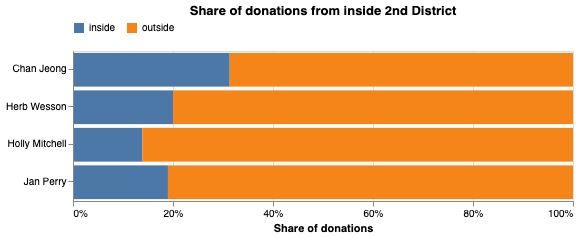

In [120]:
bars = alt.Chart(district_totals_melt, title='Share of donations from inside 2nd District').mark_bar().encode(
    x=alt.X('sum(value)', stack="normalize", title="Share of donations", axis=alt.Axis(format='%', tickCount=6)),
    y=alt.Y('candidate', title=""),
    color=alt.Color('variable',legend=alt.Legend(title="",orient='top')),
    order=alt.Order('variable', sort='ascending')
)

(bars).properties(height=150, width=500)

### Read the zip codes by county GIS officials

In [121]:
#http://public.gis.lacounty.gov/public/rest/services/LACounty_Dynamic/Administrative_Boundaries/MapServer/5
zips = gpd.read_file('/Users/mhustiles/Desktop/github/notebooks/campaign-finance/input/la_county_gis_zip_codes/la_county_gis_zip_codes_1569271283260.geojson')

In [122]:
zips.columns = zips.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [123]:
zips = zips.to_crs({'init': "epsg:4326"})

In [124]:
len(zips)

315

In [125]:
zips.columns

Index(['shape.area', 'shape.len', 'objectid', 'zipcode', 'geometry'], dtype='object')

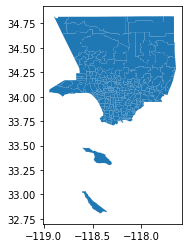

In [126]:
zips.plot()

In [127]:
second_district_zips = gpd.sjoin(geocoded_join_gdf, zips, op='within', how="inner")

In [128]:
second_district_zips.head(2)

last_name first_name committee_id              committee_name office_type  \
2    WESSON       HERB      1414475  WESSON FOR SUPERVISOR 2020         CSU   
7    WESSON       HERB      1414475  WESSON FOR SUPERVISOR 2020         CSU   

  district_number schedule   type period_beg_date period_end_date  \
2             NaN        A  Other          1/1/18        12/31/18   
7             NaN        A  Other          1/1/18        12/31/18   

  election_date       date  amount_rcvd  amount_pd description  \
2           NaN 2018-12-18         1500        0.0               
7           NaN 2018-12-21         1500        0.0               

  contributor_first_name                              contributor_last_name  \
2                         Angelenos for Safe Transportation PAC Sponsore...   
7                                        Janna Zurita for City Council 2019   

  contributor_address contributor_address_2 contributor_city  \
2    249 E Ocean Blvd               Ste 685       Long Beach   
7    249 E Ocean Blvd               Ste 685       Long Beach   

  contributor_state contributor_zip_code contributor_zip_code_ext occupation  \
2                CA                90802                     8832              
7                CA                90802                     8832              

  employer  rec_id      cycle  monthyear candidate_name  \
2             2546  2018-2019 2018-12-01    Herb Wesson   
7             2546  2018-2019 2018-12-01    Herb Wesson   

  nu_contributor_address                             full_address  \
2       249 E Ocean Blvd  249 E Ocean Blvd, Long Beach, CA, 90802   
7       249 E Ocean Blvd  249 E Ocean Blvd, Long Beach, CA, 90802   

  candidate_slug  year month   months week accuracy  \
2    herb_wesson  2018    12  12/2018   51  ROOFTOP   
7    herb_wesson  2018    12  12/2018   51  ROOFTOP   

                             formatted_address  \
2  249 E Ocean Blvd, Long Beach, CA 90802, USA   
7  249 E Ocean Blvd, Long Beach, CA 90802, USA   

                              input_string   latitude   longitude  \
2  249 E Ocean Blvd, Long Beach, CA, 90802  33.767313 -118.190096   
7  249 E Ocean Blvd, Long Beach, CA, 90802  33.767313 -118.190096   

                                 geometry  index_right    shape.area  \
2  POINT (-118.1900963 33.76731270000001)           93  1.684347e+08   
7  POINT (-118.1900963 33.76731270000001)           93  1.684347e+08   

       shape.len  objectid zipcode  
2  181881.275506       152   90802  
7  181881.275506       152   90802

In [129]:
second_district_zips.columns = second_district_zips.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

### How much did each of the candidates raise by zip?

In [130]:
sum_by_zip = pd.pivot_table(second_district_zips, values='amount_rcvd', index=['zipcode'], columns=['candidate_slug'], aggfunc=np.sum, fill_value=0).reset_index()

In [131]:
sum_by_zip["total"] = sum_by_zip.sum(axis=1)

In [132]:
sum_by_zip.columns = sum_by_zip.columns.to_series().str.join('')

### How much did all of the candidates raise by zip?

In [133]:
sum_by_zip = sum_by_zip.sort_values("total", ascending=False)

In [134]:
sum_by_zip.head()

candidate_slug zipcode  chan_jeong  herb_wesson  holly_mitchell  jan_perry  \
3                90005        5200        49550            3500       4500   
14               90017        4000        18738           12515       9250   
62               90210           0        20500            4200      17780   
44               90049           0        14949            7000      20350   
21               90024           0        17000            7500      10000   

candidate_slug  total  
3               62750  
14              44503  
62              42480  
44              42299  
21              34500

In [135]:
sum_by_zip[['zipcode', 'total']].sort_values(by='total', ascending=False)

candidate_slug zipcode  total
3                90005  62750
14               90017  44503
62               90210  42480
44               90049  42299
21               90024  34500
17               90020  32300
16               90019  30350
12               90015  30325
45               90056  29475
58               90071  28600
6                90008  28193
22               90025  27010
24               90027  26150
31               90036  25335
2                90004  24950
78               90266  23800
79               90272  22800
55               90067  22025
184              91436  21800
52               90064  21200
63               90211  21100
40               90045  20700
41               90046  20600
86               90292  20500
57               90069  20250
9                90012  20200
64               90212  20150
38               90043  18856
92               90402  18750
11               90014  16850
..                 ...    ...
108              90660   1000
194              91605   1000
215              91773    800
195              91606    700
50               90062    700
185              91501    650
211              91755    600
131              91006    500
219              91791    500
51               90063    500
189              91521    500
148              91203    500
141              91104    450
196              91607    350
49               90061    325
224              93551    300
32               90037    300
26               90029    250
19               90022    250
136              91024    225
138              91042    200
201              91724    125
107              90650    125
101              90602    100
166              91343    100
171              91354    100
203              91732    100
111              90706    100
127              90814    100
200              91723    100

[225 rows x 2 columns]

### How much was donated to all candidates from L.A. County zips? 

In [136]:
sum_by_zip.total.sum()

1578057

### How many zips in LA County donated? 

In [137]:
sum_by_zip.total.count()

225

### Which 2nd District candidate received the most in each zip? 

In [138]:
#create a dummy field because i'm bad at idxmax; 
sum_by_zip['tie'] = '0'

In [139]:
#reshape dataframe
sum_by_zip_winner = sum_by_zip[['zipcode', 'tie','chan_jeong','herb_wesson','jan_perry','holly_mitchell','total']]

In [140]:
sum_by_zip_winner['tie'] = sum_by_zip_winner['tie'].astype(int)
sum_by_zip_winner['zipcode'] = sum_by_zip_winner['zipcode'].astype(str)

In [141]:
#who won each zip?
sum_by_zip_winner['winner_dist_two'] = sum_by_zip_winner[['tie','chan_jeong','herb_wesson','jan_perry','holly_mitchell']].idxmax(axis=1)

In [142]:
#how much did each zip winner raise from there? 
sum_by_zip_winner['winner_total'] = sum_by_zip_winner[['tie','chan_jeong','herb_wesson','jan_perry','holly_mitchell']].max(axis=1)

In [143]:
sum_by_zip_winner['winner_dist_two']= sum_by_zip_winner['winner_dist_two'].str.title().str.replace('_',' ')

In [144]:
sum_by_zip_winner

candidate_slug zipcode  tie  chan_jeong  herb_wesson  jan_perry  \
3                90005    0        5200        49550       4500   
14               90017    0        4000        18738       9250   
62               90210    0           0        20500      17780   
44               90049    0           0        14949      20350   
21               90024    0           0        17000      10000   
17               90020    0        6500        15600       7200   
16               90019    0         550        16950       8700   
12               90015    0        1000        13500      15225   
45               90056    0           0         9300       7150   
58               90071    0           0        15800       9800   
6                90008    0           0        11043      14250   
22               90025    0        1500         9625      13600   
24               90027    0           0        19250       5800   
31               90036    0           0        17800       7225   
2                90004    0        1300        14000       6150   
78               90266    0           0        23300          0   
79               90272    0           0        10500      12050   
55               90067    0           0        11500       6875   
184              91436    0           0        13100       5200   
52               90064    0           0         8000       3150   
63               90211    0           0        16500       4600   
40               90045    0           0        13400       5350   
41               90046    0           0         9500       5000   
86               90292    0           0         9500       7800   
57               90069    0           0         9100       8050   
9                90012    0         250         9750       9200   
64               90212    0           0        10650       7750   
38               90043    0           0         5300       3800   
92               90402    0           0        10250       3500   
11               90014    0           0         2250      14600   
..                 ...  ...         ...          ...        ...   
100              90505    0           0         1000          0   
108              90660    0           0            0          0   
215              91773    0           0          800          0   
50               90062    0           0          500        200   
195              91606    0         700            0          0   
185              91501    0           0            0        650   
211              91755    0           0            0        600   
131              91006    0           0          500          0   
219              91791    0           0            0        500   
51               90063    0           0          500          0   
189              91521    0           0            0        500   
148              91203    0           0            0          0   
141              91104    0           0          200          0   
196              91607    0           0            0        350   
49               90061    0           0            0        325   
224              93551    0           0            0        100   
32               90037    0         200            0        100   
19               90022    0           0            0          0   
26               90029    0           0            0        250   
136              91024    0           0            0        225   
138              91042    0           0            0        200   
201              91724    0           0            0          0   
107              90650    0           0          125          0   
101              90602    0           0            0          0   
166              91343    0           0            0        100   
171              91354    0           0            0        100   
203              91732    0           0          100          0   
111              90706    0           0        

### Which were the top zips for each candidate? 

In [145]:
sum_by_zip_winner.head()

candidate_slug zipcode  tie  chan_jeong  herb_wesson  jan_perry  \
3                90005    0        5200        49550       4500   
14               90017    0        4000        18738       9250   
62               90210    0           0        20500      17780   
44               90049    0           0        14949      20350   
21               90024    0           0        17000      10000   

candidate_slug  holly_mitchell  total winner_dist_two  winner_total  
3                         3500  62750     Herb Wesson         49550  
14                       12515  44503     Herb Wesson         18738  
62                        4200  42480     Herb Wesson         20500  
44                        7000  42299       Jan Perry         20350  
21                        7500  34500     Herb Wesson         17000

In [146]:
sum_by_zip_winner.to_csv('output/sum_by_hood_winner.csv')

### Remove 2nd District rows with no contributions

In [147]:
sum_by_zip_winner = sum_by_zip_winner[(sum_by_zip_winner['winner_total'] != 0)]

In [148]:
len(sum_by_zip_winner)

225

### How many zips did each 2nd District candidate win?

In [149]:
sum_by_zip_winner.winner_dist_two.value_counts()

Herb Wesson       134
Jan Perry          62
Holly Mitchell     25
Chan Jeong          4
Name: winner_dist_two, dtype: int64

### How much did each 2nd District candidate raise from just LA zips?

In [150]:
sum_by_zip_winner[['chan_jeong','herb_wesson','jan_perry','holly_mitchell']].agg('sum')

candidate_slug
chan_jeong         38100
herb_wesson       865551
jan_perry         455135
holly_mitchell    219271
dtype: int64

### Merge the neighborhoods/winner geography back onto our 2nd District winners table

In [151]:
second_district_zips = zips.merge(sum_by_zip_winner, on='zipcode')

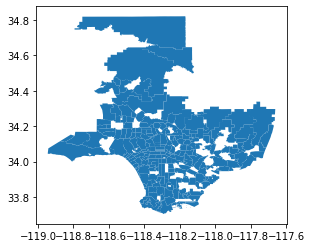

In [152]:
second_district_zips.plot()

### Export spatial file with winners, totals by neighborhood

In [153]:
second_district_zips.to_file('output/second_district_zips_sum.geojson', driver="GeoJSON")

### Generate winners by zips to MBTiles

In [154]:
!tippecanoe -z15 -f -o output/second_district_zips_sum.mbtiles output/second_district_zips_sum.geojson

For layer 0, using name "second_district_zips_sum"
229 features, 1116969 bytes of geometry, 10338 bytes of separate metadata, 13064 bytes of string pool
  99.9%  15/5625/13109  


### Wesson donations

In [155]:
wesson = districttwo[districttwo['candidate_name'] == 'Herb Wesson']

In [156]:
wessonoutside = wesson[wesson['type'] == 'Other']

In [157]:
wessonoutsidelarge = wessonoutside[wessonoutside['amount_rcvd'] == 1500]

In [158]:
wessonoutsidelargesmall = wessonoutsidelarge[['contributor_last_name', 'contributor_city', 'amount_rcvd', 'date']].sort_values(by='contributor_last_name', ascending=True)
  

In [159]:
pd.set_option('display.max_rows', None)
wessonoutsidelargesmall

contributor_last_name     contributor_city  \
77046                                   2 Down Front Inc          Los Angeles   
76331                                        2CGPak, LLC          Los Angeles   
77103                                2G Investments, LLC                Azusa   
76953                                     7-Eleven, Inc.               Irving   
76337                            9712 Oak Pass Road, LLC          Miami Beach   
77086                                        Actium, LLP          Los Angeles   
77093                                     Active USA Inc               Vernon   
76359                  Advocate's Competitive Edge, Inc.       South Pasadena   
76367                           Aeroplex Aerolease Group           Long Beach   
76328                             Albright, Yee & Schmit          Los Angeles   
76338                                 Alevy & Associates           Long Beach   
77026                               Allied Pacific / IPA             Alhambra   
77080                         American Chemistry Council           Washington   
76339                           Amusement Industry, Inc.           Long Beach   
1543   Angelenos for Safe Transportation PAC Sponsore...           Long Beach   
77027                                    Athens Services     City Of Industry   
77104                                Atlas Capital Group             New York   
1547                      Autumn Burke for Assembly 2018          Los Angeles   
77012                         BBB Group LLC DBA: M Grill          Los Angeles   
76379                               BNSF Railway Company           Fort Worth   
77058                                        Big E Pizza          Signal Hill   
76973                                        Boucher LLP       Woodland Hills   
1797                    Building California Together PAC           Sacramento   
1809   Building Industry Association of Southern Cali...          Los Angeles   
1796   CA Beer & Beverage Distributors Community Affairs           Sacramento   
1807                  CA Independent Petroleum Assoc PAC               Irvine   
77791  CA Teamsters Public Affairs Council, Public Af...           Sacramento   
76977                                      CAL NED, INC.          Los Angeles   
76334                                     CGI Strategies       Woodland Hills   
76368                            CORBeL Architects, Inc.          Los Angeles   
76348                                  CRC Services, LLC           Chatsworth   
76406                                   CRCD Enterprises          Los Angeles   
76351                                         Cadiz Inc.          Los Angeles   
1814                California Apartment Association PAC           Sacramento   
76352                      California Landscape & Design               Upland   
1787   California Real Estate PAC - California Associ...          Los Angeles   
77036                     Centene Management Company LLC          Saint Louis   
77048                                             Centro  Rancho Palos Verdes   
77013                                  Choi Bo Sung Inc.          Los Angeles   
76995                           Chosun Galbee Restaurant          Los Angeles   
77073                   Chun-Ha Insurance Services, Inc.         Garden Grove   
76978                                       Clean Energy        Newport Beach   
1801   Committee to Expand the Middle Class, Supporte...        San Francisco   
76347                      Community Builders Group, LLC             Pasadena   
76405                         Concourse Concessions, Inc           El Segundo   
77105                               Cooper and Brain Inc           Wilmington   
76340                                Cornerstone JC Inc.         La Crescenta   
76932                                              Crews            Las Vegas   
77016  Critical Solutions Protective Services Group, Inc        Be

### Mitchell Donations

In [160]:
mitchell = districttwo[districttwo['candidate_name'] == 'Holly Mitchell']

In [161]:
mitchelloutside = mitchell[mitchell['type'] == 'Other']

In [162]:
mitchelloutsidelarge = mitchelloutside[mitchelloutside['amount_rcvd'] == 1500]

In [163]:
mitchelloutsidelarge[['contributor_last_name', 'contributor_city', 'amount_rcvd', 'date']].sort_values(by='date', ascending=True)

contributor_last_name     contributor_city  \
1628                          Kamlager for Assembly 2020          Los Angeles   
76732                              Gilead Sciences, Inc.          Foster City   
76733                  Gordon, Edelstein, Krepack, Grant          Los Angeles   
76734                                             Intuit            San Diego   
76735                                  Johnson & Johnson           Washington   
76736                  Liberty Dental Plan of California               Irvine   
76737                                   Mallinckrodt LLC           Washington   
76731                        Ghost Management Group, LLC               Irvine   
76738                           Marcus, Regaldo & Marcus           Sacramento   
76740                         Merck, Sharp & Dohme Corp.   Whitehouse Station   
76741                    Morongo Band of Mission Indians              Banning   
76742                                  Murphys Bowl, LLC             Bellevue   
76743                           NextEra Energy Resources           Juno Beach   
76744                       Novartis Finance Corporation           Fort Worth   
76745                                       Pacific Life        Newport Beach   
76739                          Maxim Healthcare Services             Columbia   
76730                                     Genentech Inc.  South San Francisco   
76729                                          Fox Group          Los Angeles   
76728             First American Title Insurance Company           Scottsdale   
76713                      Bristol-Meyers Squibb Company             New York   
76714                                Calpine Corporation              Houston   
76715                          Capital One Services, LLC               Reston   
77771  Steamfitters & Refrigeration U.A. Local 250 PA...              Gardena   
76717                                Celgene Corporation               Summit   
76718                     Centene Management Company LLC          Saint Louis   
76719                             Charter Communications          Saint Louis   
76720               Comcast Financial Agency Corporation         Philadelphia   
76721                   Community Loans of America, Inc.              Atlanta   
76722                            DaVita, Total Care Inc.          Los Angeles   
76723                               Eaze Solutions, Inc.        San Francisco   
76724         Edison International & Affiliated Entities           Sacramento   
76725                                     Facebook, Inc.           Menlo Park   
76726                 Family Justice Advocates in Action             La Jolla   
76727                                Farmers Group, Inc.       Woodland Hills   
76746                                 Paramount Pictures          Los Angeles   
76747                   Pechanga Band of Luiseno Indians             Temecula   
76748                                             Pfizer              Memphis   
76749                                 PG & E Corporation        San Francisco   
77756  American Federation of State, County & Municip...           Sacramento   
77757          Cal Fire Local 2881 Small Contributor PAC           Sacramento   
77758  California Dental Political Action Committee S...           Sacramento   
77759             California Federation of Teachers COPE              Burbank   
77760  California State Retirees PAC Small Contributo...           Sacramento   
77761  International Alliance of Theatrical Stage Emp...          Los Angeles   
77762  International Brotherhood of Electrical Worker...             Pasadena   
77763  Personal Insurance Federation Agents and Emplo...           Sacramento   
77764  Political Action for Classified Employees of C...           Sacramento   
77765  SEIU California State Council Small Contributo...           Sacramento   
77766                          SEIU Local 2015 State PAC          

### Perry Donations

In [164]:
perry = districttwo[districttwo['candidate_name'] == 'Jan Perry']

In [165]:
perryoutside = perry[perry['type'] == 'Other']

In [166]:
perryoutsidelarge = perryoutside[perryoutside['amount_rcvd'] == 1500]

In [167]:
perryoutsidelarge[['contributor_last_name', 'contributor_city', 'amount_rcvd', 'date']].sort_values(by='contributor_last_name', ascending=True)

contributor_last_name contributor_city  \
76844                                  5124 York LLC      Los Angeles   
76807          523 SOUTH LOS ANGELES INVESTMENT, LLC   WEST HOLLYWOOD   
76826                Broadway Exchange Building, LLC      Los Angeles   
76881               Employee Retention Benefits Inc.      West Covina   
76867                           Eternal Produce Inc.         Alhambra   
76808                          FISCH PROPERTIES L.P.    BEVERLY HILLS   
76839    Fashion Institute of Design & Merchandising      Los Angeles   
76828                           Forest Lawn Mortuary         Glendale   
76884               Golden Life Global Holdings Corp        Placentia   
76853                                          Hirsh      Studio City   
76885                              Howard Industries      Culver City   
76882                           JJ Acu & Herb Clinic      Los Angeles   
76827                           L.A.R.D. Investments  Santa Fe Spring   
76817                                      LAACO Ltd      Los Angeles   
76883                Land Use Developers Corporation      Los Angeles   
76829                          Lena Construction LLC      Los Angeles   
1767   Los Angeles County Electrical Contractors PAC         Pasadena   
76875                Los Angeles Kitchen Workers LLC           Encino   
76818               Los Angeles United Investment Co      Los Angeles   
76878                            MPT Family Partners      Los Angeles   
76866                      Pacific Coast Council PAC       Washington   
76841                   SPM-Starpoint Properties LLC    Beverly Hills   
76819                                      Samko LLC      Los Angeles   
76834                      The Greenwald Company LLC        San Diego   
76842                  The Los Angeles Flower Market      Los Angeles   
76847                                    Venice#4694      Los Angeles   
76809                     WESTPORT CONSTRUCTION, INC         MONROVIA   
76835                  Withee Malcolm Architects LLP         Torrance   

       amount_rcvd       date  
76844         1500 2019-04-01  
76807         1500 2019-01-29  
76826         1500 2019-02-22  
76881         1500 2019-06-13  
76867         1500 2019-05-31  
76808         1500 2019-01-29  
76839         1500 2019-03-25  
76828         1500 2019-03-01  
76884         1500 2019-06-19  
76853         1500 2019-04-16  
76885         1500 2019-06-20  
76882         1500 2019-06-13  
76827         1500 2019-02-22  
76817         1500 2019-02-10  
76883         1500 2019-06-14  
76829         1500 2019-03-05  
1767          1500 2019-02-27  
76875         1500 2019-06-10  
76818         1500 2019-02-14  
76878         1500 2019-06-12  
76866         1500 2019-05-30  
76841         1500 2019-03-29  
76819         1500 2019-02-14  
76834         1500 2019-03-15  
76842         1500 2019-03-29  
76847         1500 2019-04-08  
76809         1500 2019-01-29  
76835         1500 2019-03-15